In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=10
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'BILL.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2002-03-31,1757,-1398,359,177,412,1217,664,2407,0,...,6731,331,0,0,878,2001,3463,126,-60,58.18
1,2002-06-30,1776,-1435,341,164,416,1229,620,2407,0,...,6767,361,0,0,1016,2227,3824,392,-126,58.18
2,2002-09-30,1807,-1360,447,235,582,1224,635,2545,0,...,6889,365,0,0,1074,2227,3880,412,-78,58.18
3,2002-12-31,1737,-1305,432,224,596,1107,669,2513,0,...,6873,372,0,0,925,1928,3640,409,-109,58.18
4,2003-03-31,1846,-1162,684,200,491,1143,654,2459,0,...,6887,384,0,0,939,1728,3454,258,-163,54.40


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
83,2022-12-31,2023-02-11,228.04,11971,-8534,3437,940,2046,5006,7305,...,2246,51415,6702,0,2404,12991,2796,22161,1692,-990
84,2023-03-31,2023-04-21,248.56,11495,-8487,3008,639,2318,5001,7523,...,2242,51315,5637,0,2379,11730,4251,22187,-339,-768
85,2023-06-30,2023-07-21,248.56,9953,-8142,1811,-481,1286,4369,6941,...,2254,49553,4827,0,3650,11961,4274,22363,331,-798
86,2023-09-30,2023-10-21,248.56,10210,-7702,2508,656,1363,4577,6568,...,2251,48933,5030,0,3376,11472,4207,21183,1082,-638
87,2023-12-31,2024-02-11,248.56,9566,-7341,2225,-330,2304,3804,6137,...,2227,47926,5352,0,2704,10965,4696,20981,2216,-973


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

SEK=X: No price data found, symbol may be delisted (1d 2003-07-02 00:00:00 -> 2003-09-30 00:00:00)


/Users/zsolt.nagy/Desktop/projects/Economy/valueinvesting/utils.py:52: RuntimeWarning: Mean of empty slice.
  result_series.append(data[columns].values.mean())
/Users/zsolt.nagy/Desktop/projects/Economy/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
83,2022-12-31,2023-02-11,228.04,11971,-8534,3437,940,2046,5006,7305,...,51415,6702,0,2404,12991,2796,22161,1692,-990,10.721097
84,2023-03-31,2023-04-21,248.56,11495,-8487,3008,639,2318,5001,7523,...,51315,5637,0,2379,11730,4251,22187,-339,-768,10.432528
85,2023-06-30,2023-07-21,248.56,9953,-8142,1811,-481,1286,4369,6941,...,49553,4827,0,3650,11961,4274,22363,331,-798,10.518236
86,2023-09-30,2023-10-21,248.56,10210,-7702,2508,656,1363,4577,6568,...,48933,5030,0,3376,11472,4207,21183,1082,-638,10.805716
87,2023-12-31,2024-02-11,248.56,9566,-7341,2225,-330,2304,3804,6137,...,47926,5352,0,2704,10965,4696,20981,2216,-973,10.657495


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
83,2022-12-31,2023-02-11,228.04,11971,-8534,3437,940,2046,5006,7305,...,51415,6702,0,2404,12991,2796,22161,1692,-990,10.721097
84,2023-03-31,2023-04-21,248.56,11495,-8487,3008,639,2318,5001,7523,...,51315,5637,0,2379,11730,4251,22187,-339,-768,10.432528
85,2023-06-30,2023-07-21,248.56,9953,-8142,1811,-481,1286,4369,6941,...,49553,4827,0,3650,11961,4274,22363,331,-798,10.518236
86,2023-09-30,2023-10-21,248.56,10210,-7702,2508,656,1363,4577,6568,...,48933,5030,0,3376,11472,4207,21183,1082,-638,10.805716
87,2023-12-31,2024-02-11,248.56,9566,-7341,2225,-330,2304,3804,6137,...,47926,5352,0,2704,10965,4696,20981,2216,-973,10.657495


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2002-04-22,25.142439,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,0.485515,0.514485,5.774856,16.89426,17.058252,8.421687,0.204326,0.10074,0.105185,0.216646
1,2002-04-29,25.022137,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,0.485515,0.514485,5.774856,16.89426,17.058252,8.421687,0.204326,0.10074,0.105185,0.216646
2,2002-05-06,23.578558,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,0.485515,0.514485,5.774856,16.89426,17.058252,8.421687,0.204326,0.10074,0.105185,0.216646
3,2002-05-13,24.790091,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,0.485515,0.514485,5.774856,16.89426,17.058252,8.421687,0.204326,0.10074,0.105185,0.216646
4,2002-05-20,24.042652,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,0.485515,0.514485,5.774856,16.89426,17.058252,8.421687,0.204326,0.10074,0.105185,0.216646


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2002-04-22,25.142439,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,8.421687,0.204326,0.10074,0.105185,0.216646,2.066083,0.447609,0.208137,0.642258,1.966112
1,2002-04-29,25.022137,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,8.421687,0.204326,0.10074,0.105185,0.216646,2.056198,0.445468,0.207141,0.641262,1.956704
2,2002-05-06,23.578558,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,8.421687,0.204326,0.10074,0.105185,0.216646,1.937571,0.419768,0.195191,0.629311,1.843818
3,2002-05-13,24.790091,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,8.421687,0.204326,0.10074,0.105185,0.216646,2.037129,0.441336,0.205220,0.639341,1.938558
4,2002-05-20,24.042652,2002-03-31,1757.0,12.16913,56.170505,58.18,744.0,12.7879,412.0,...,8.421687,0.204326,0.10074,0.105185,0.216646,1.975708,0.428030,0.199033,0.633153,1.880110


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

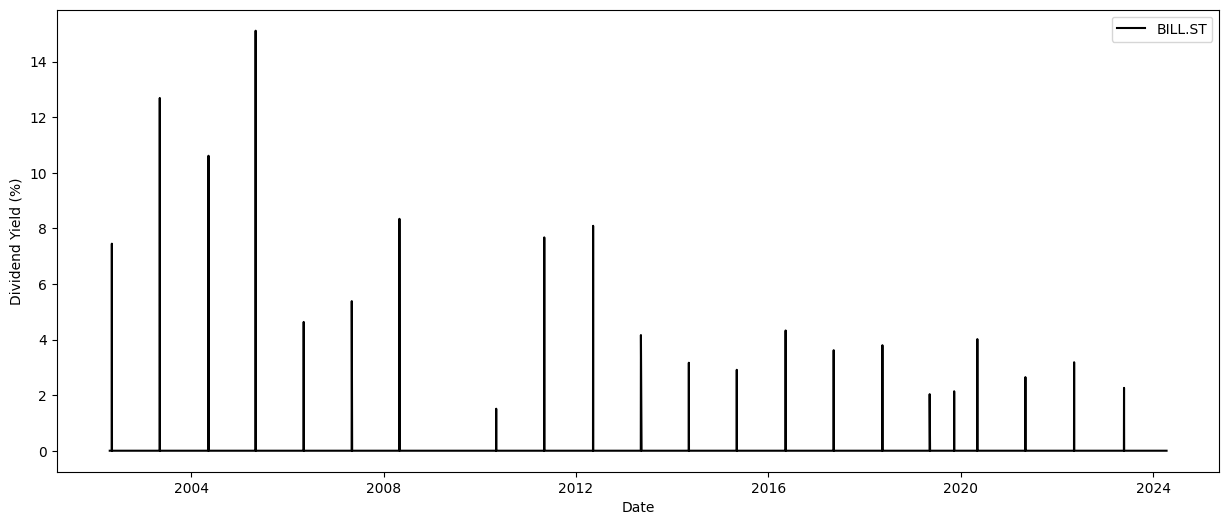

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.656103
share_price      1.000000
Name: share_price, dtype: float64


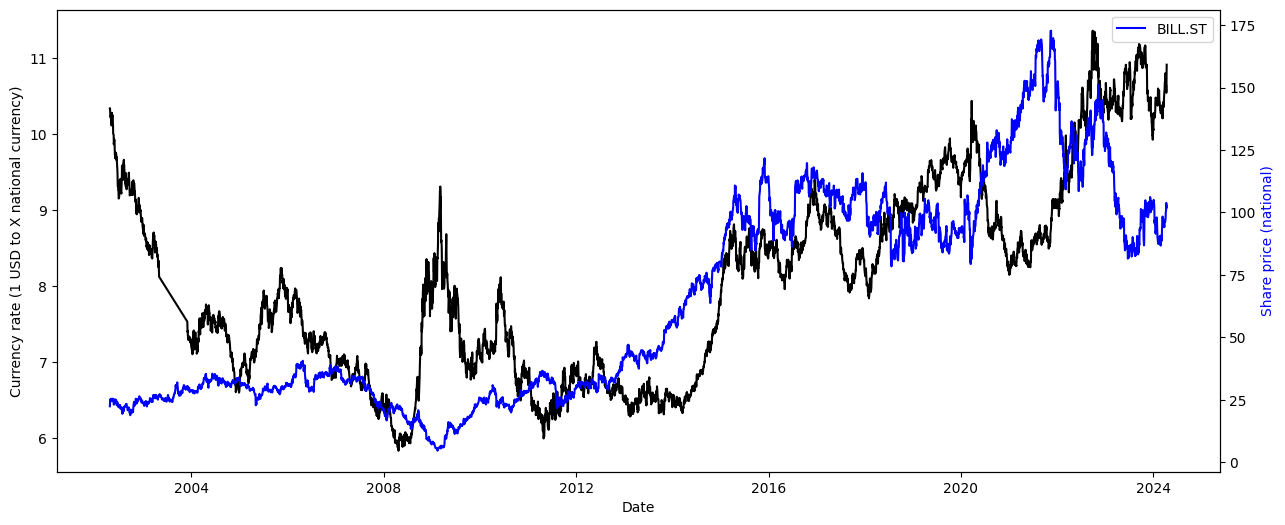

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

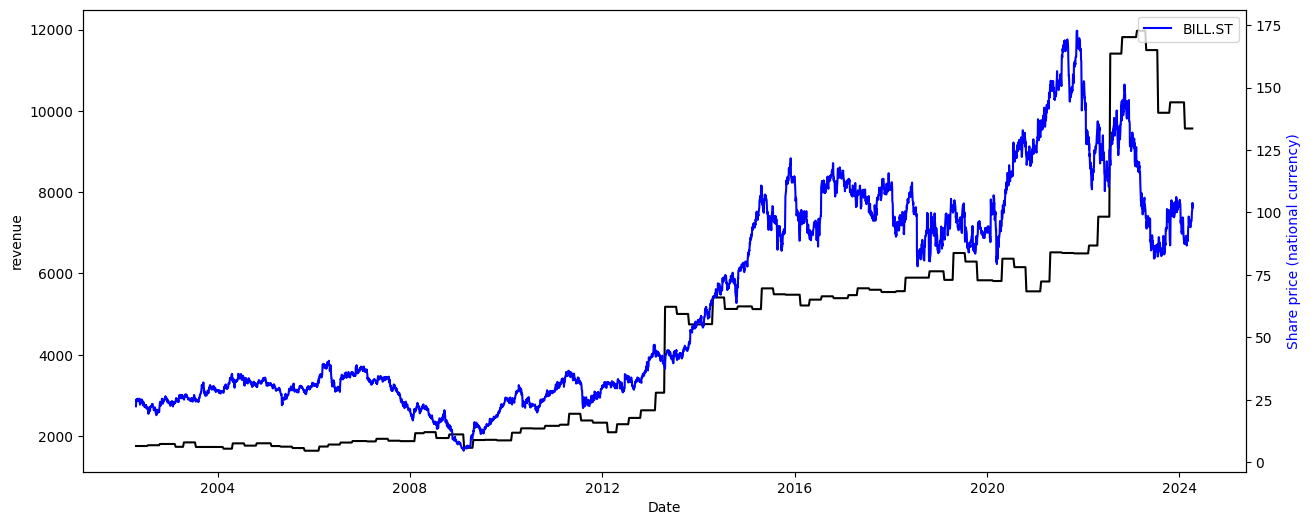

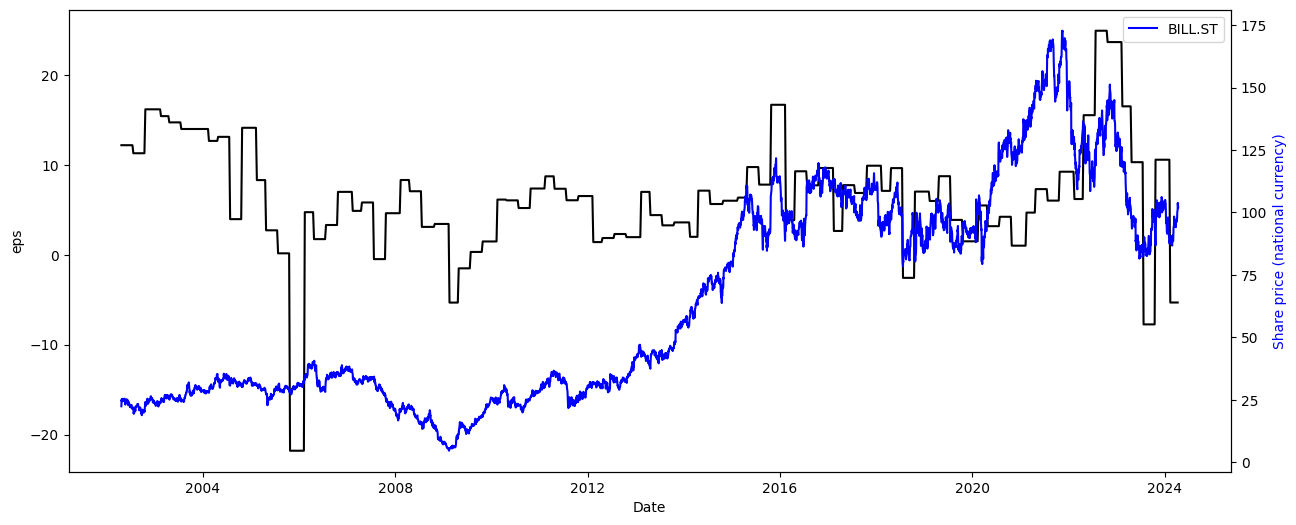

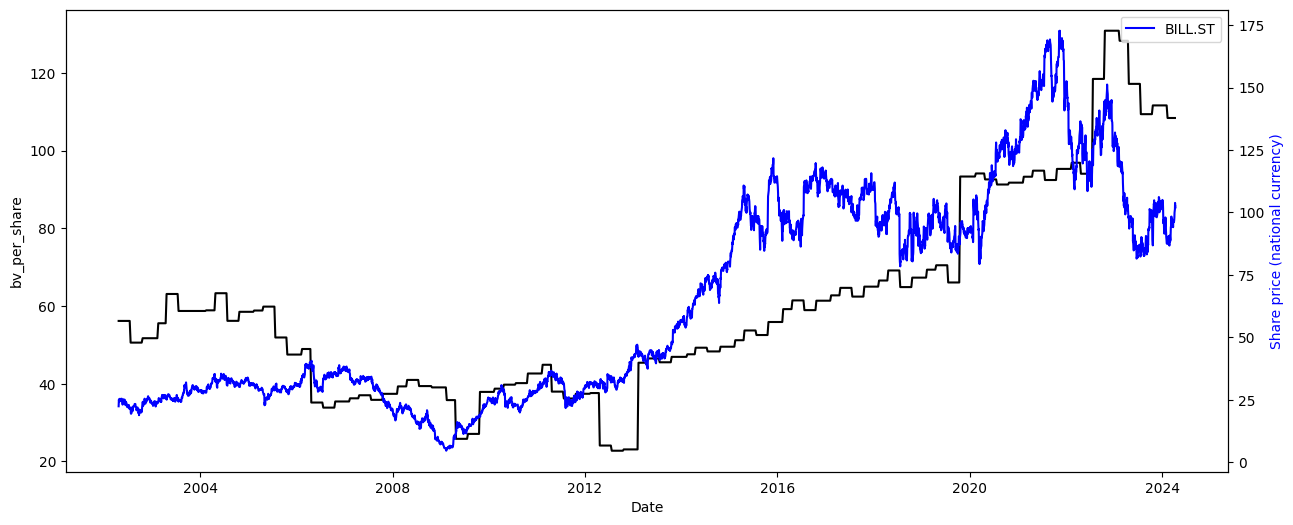

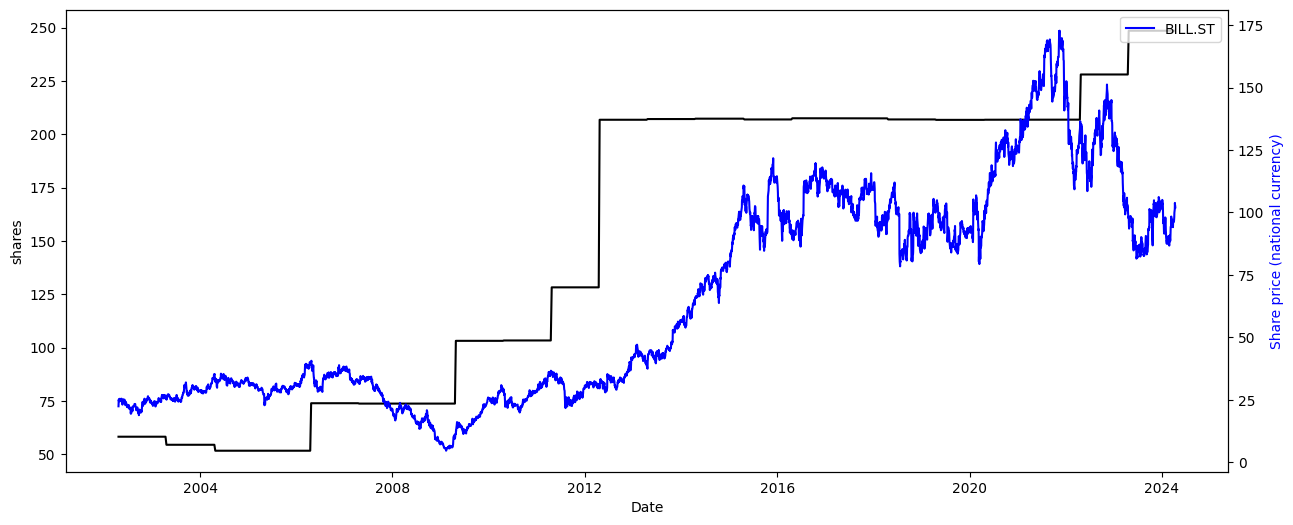

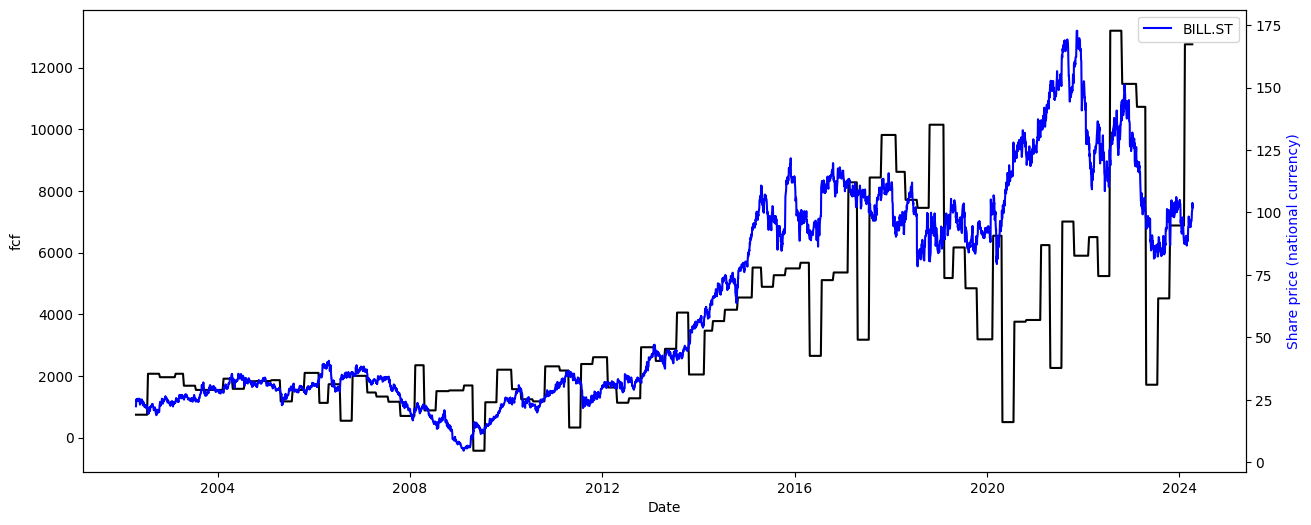

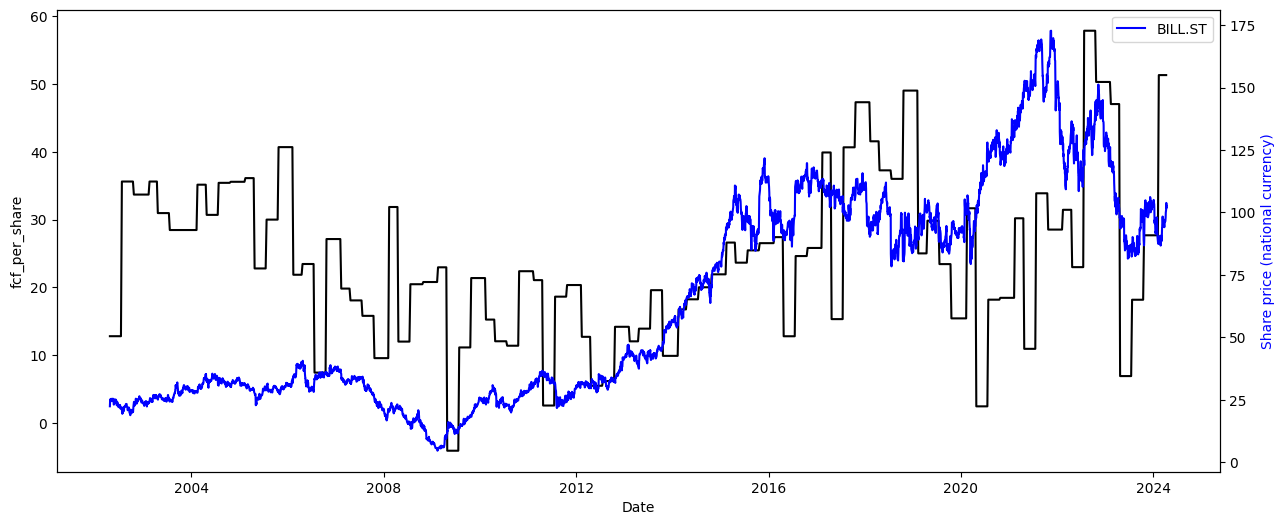

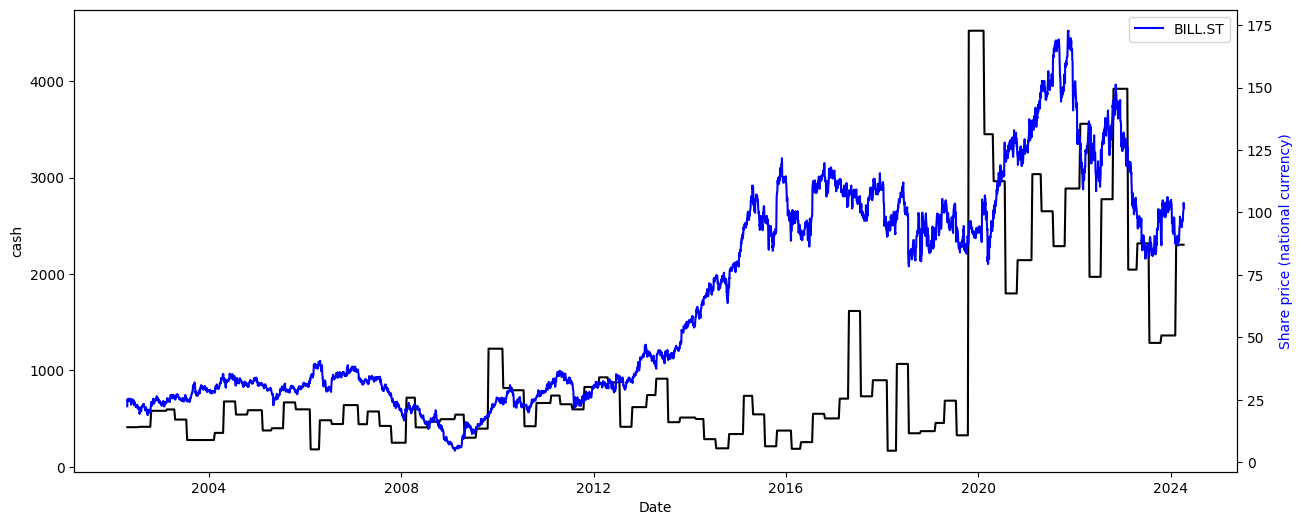

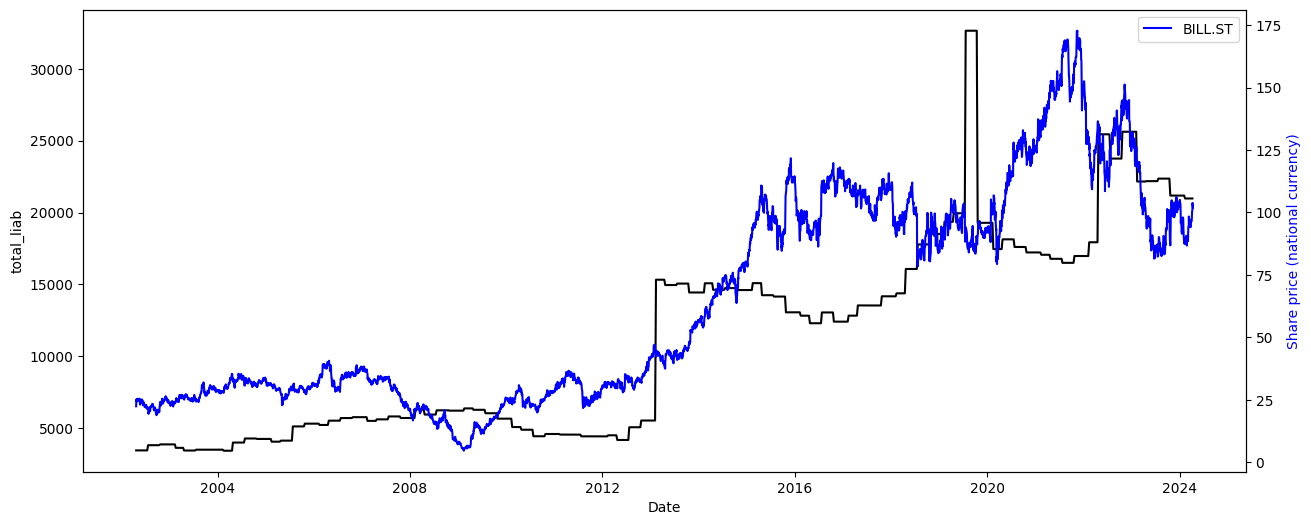

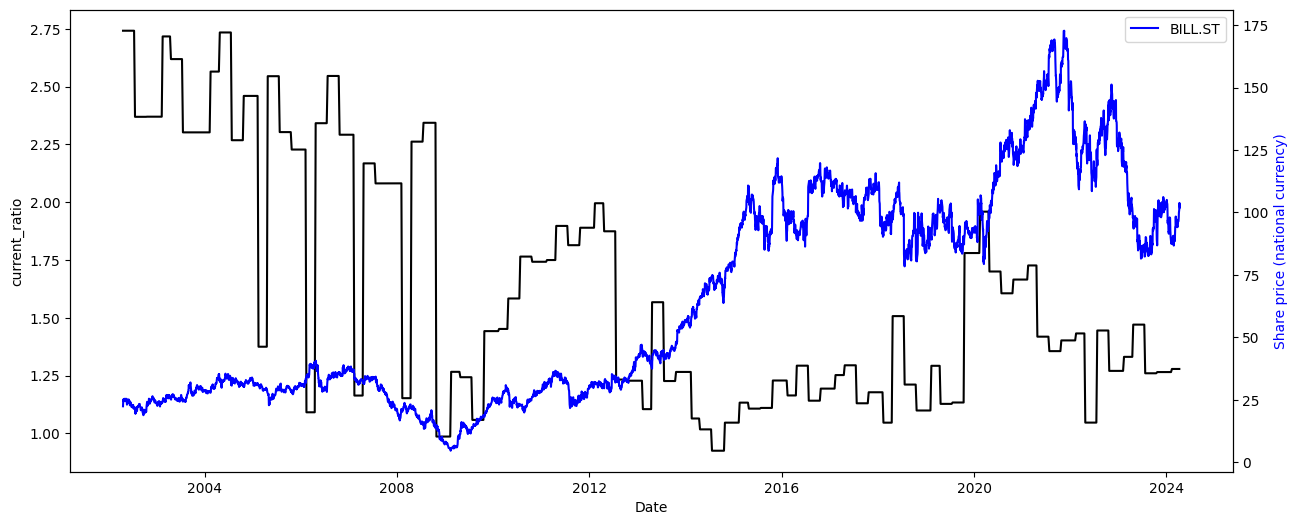

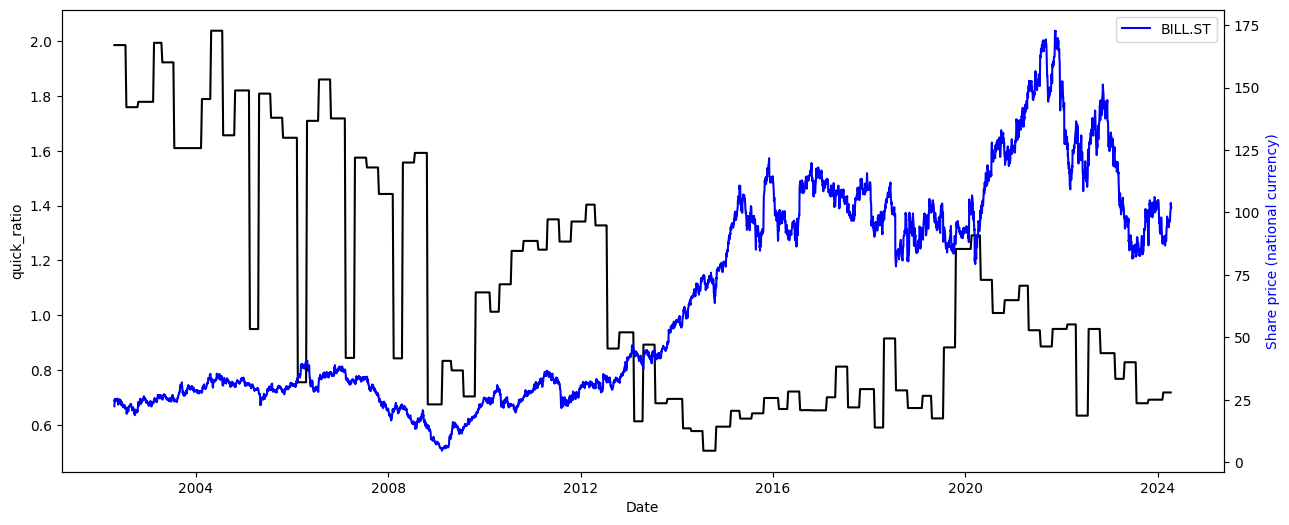

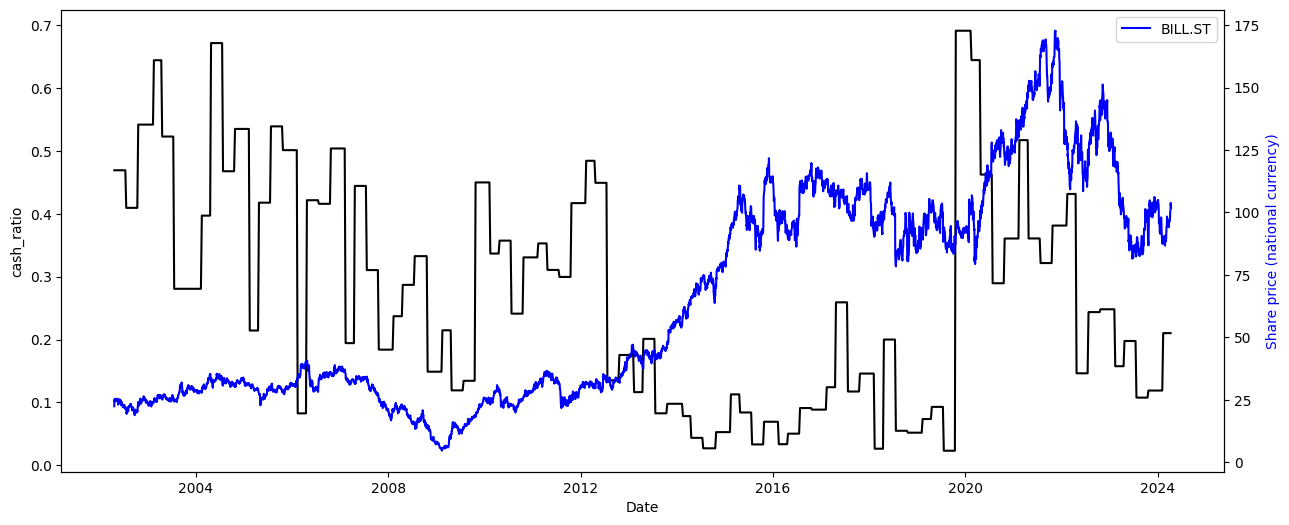

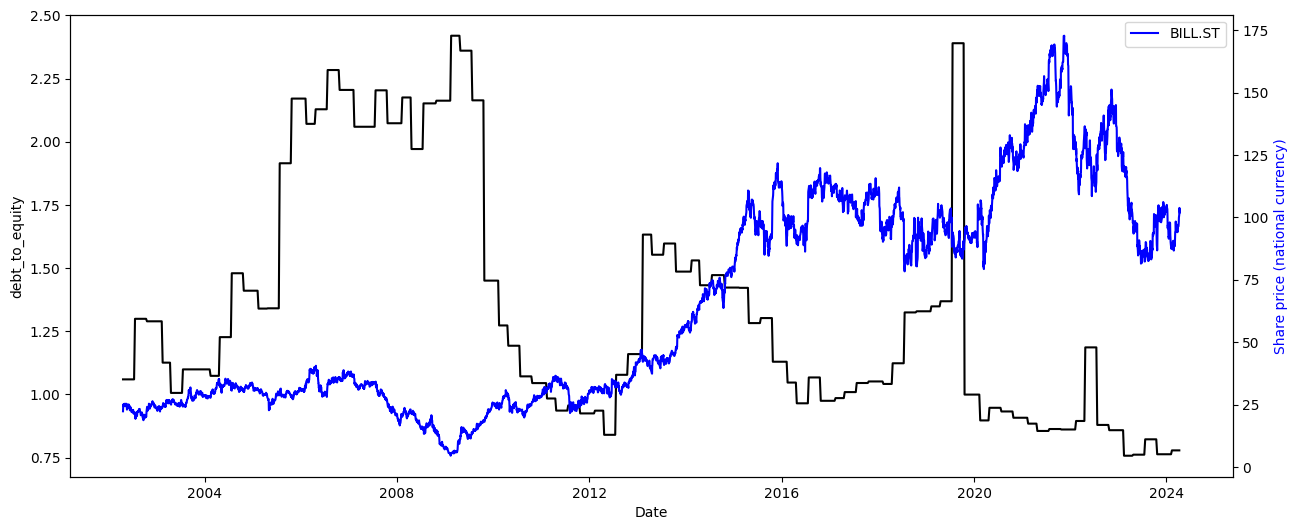

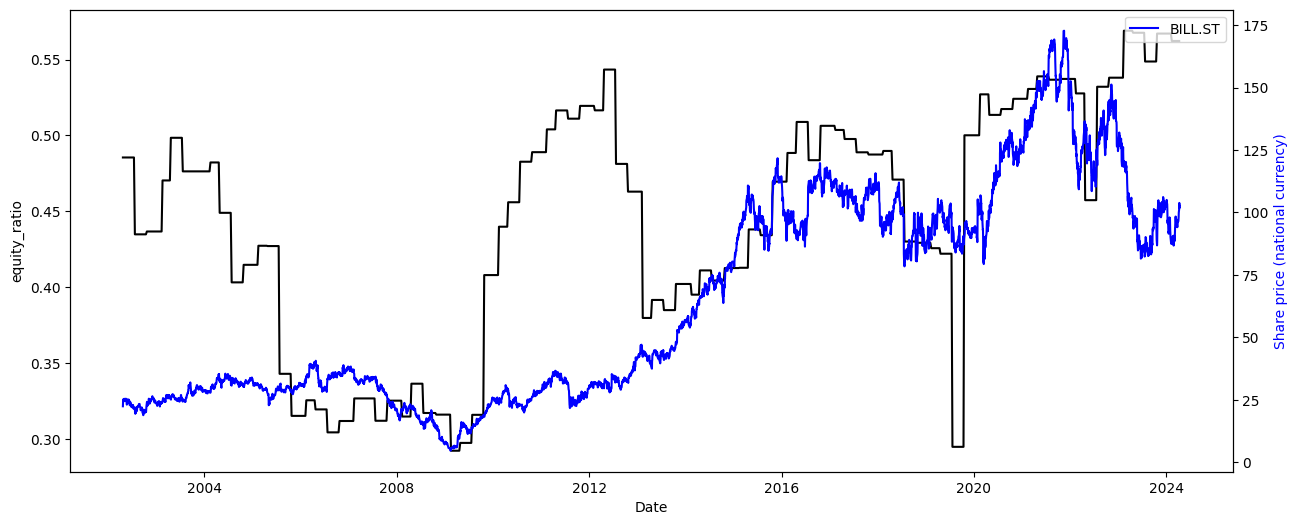

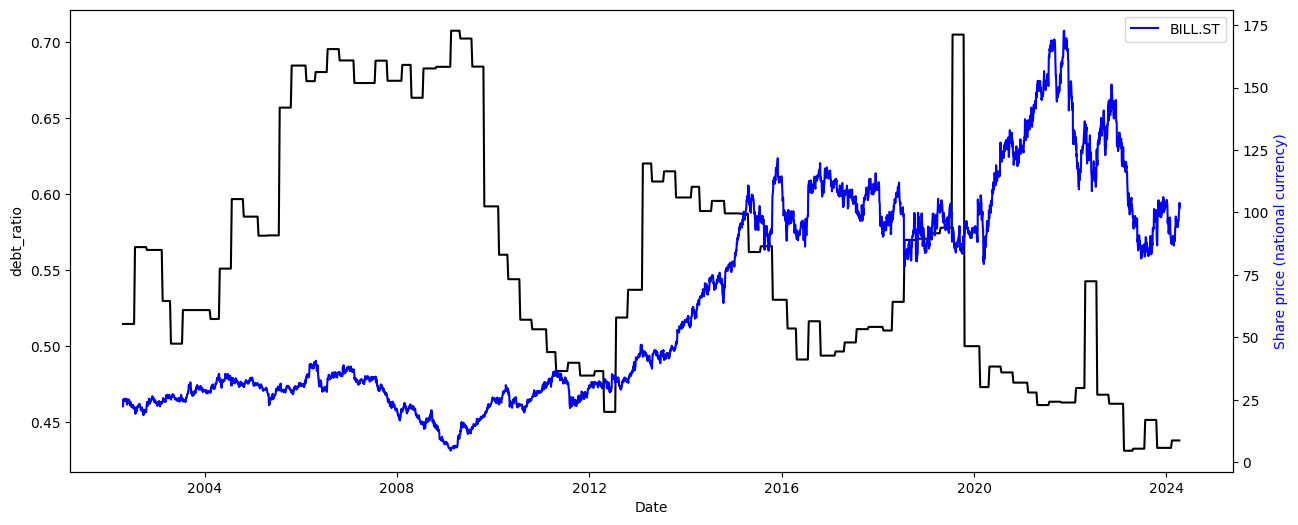

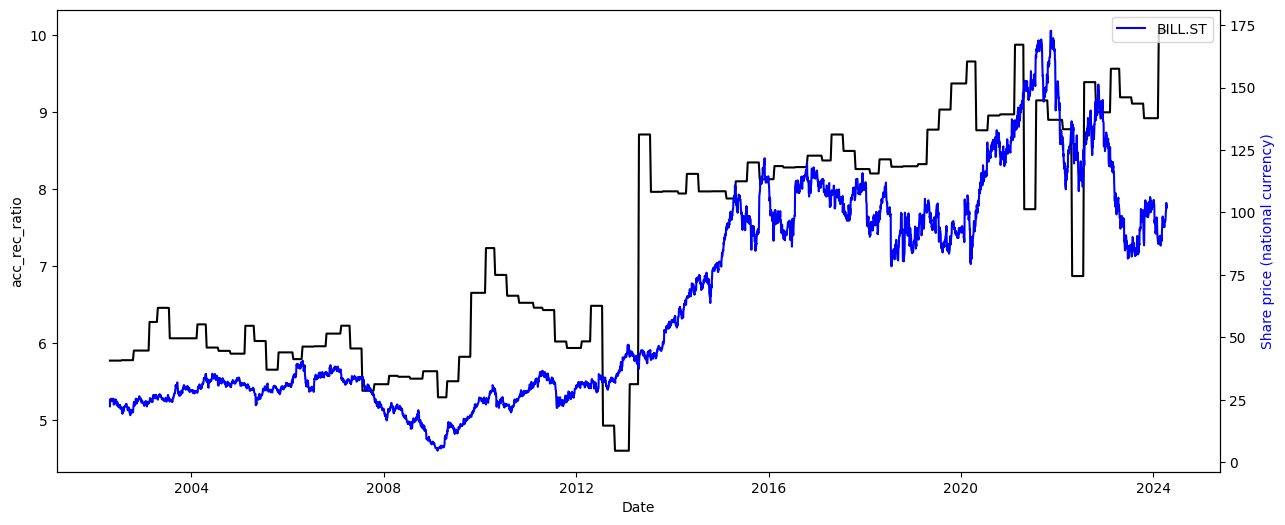

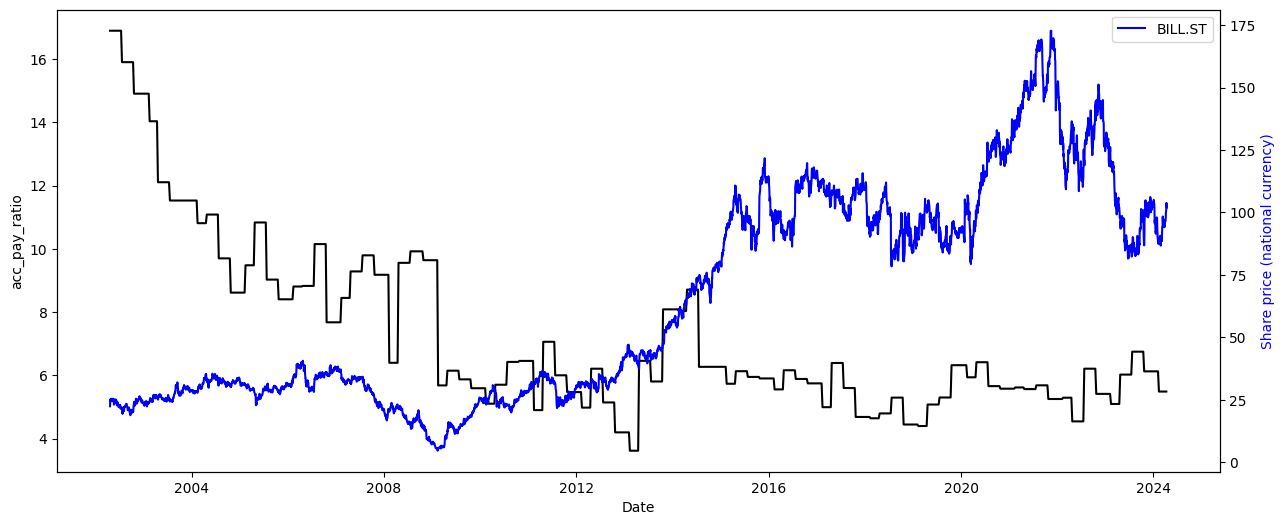

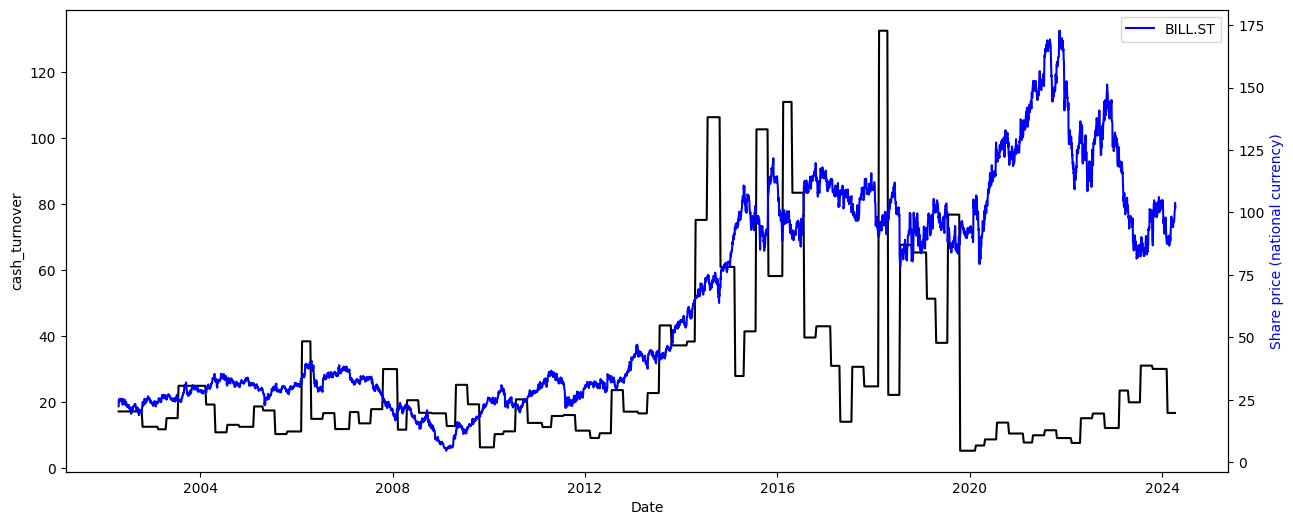

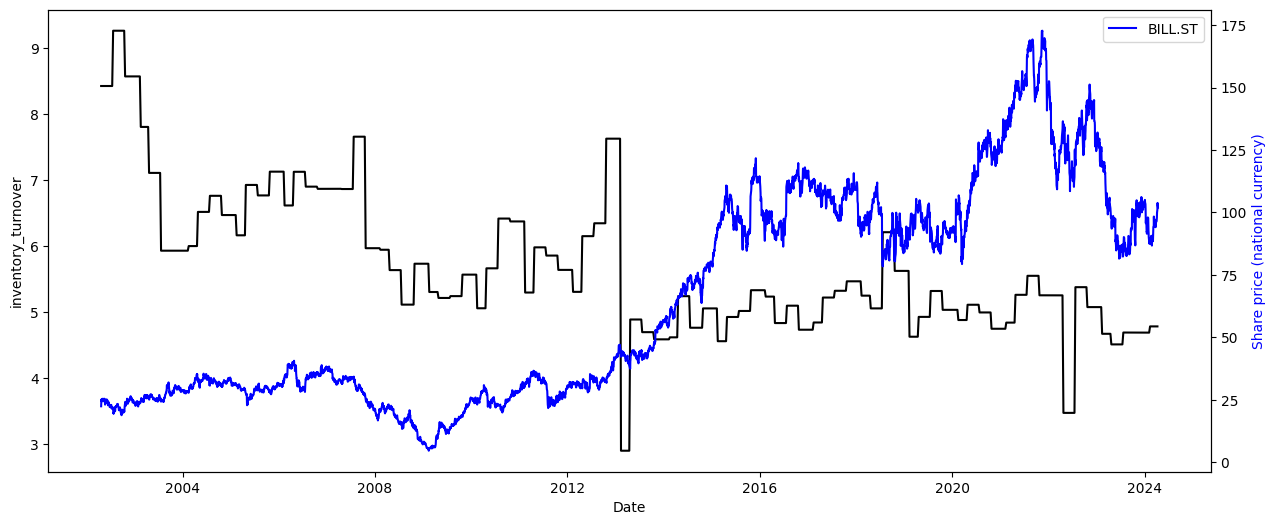

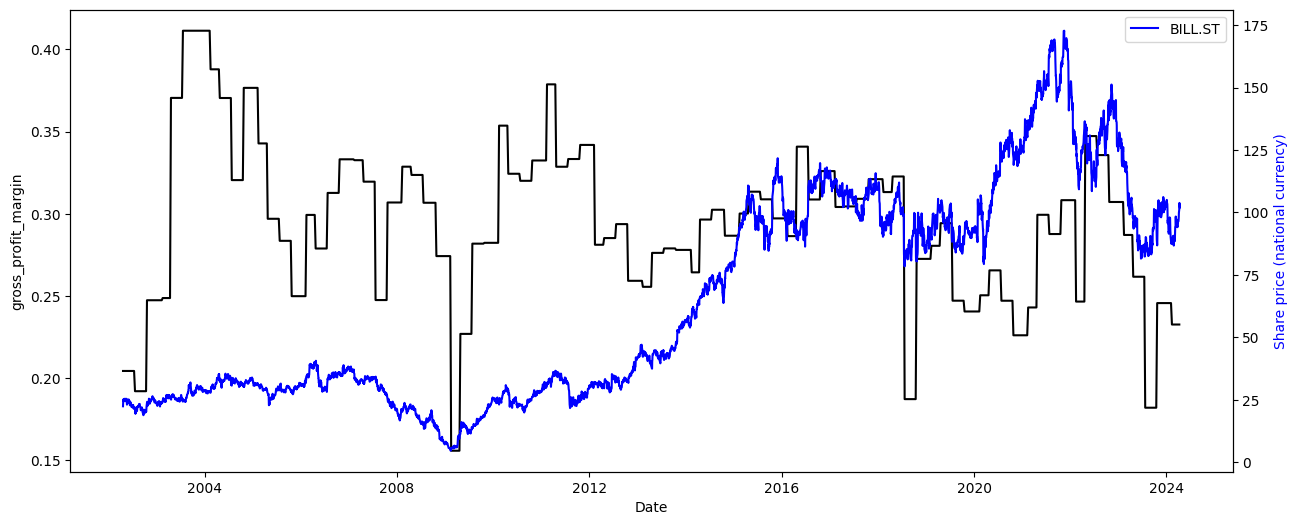

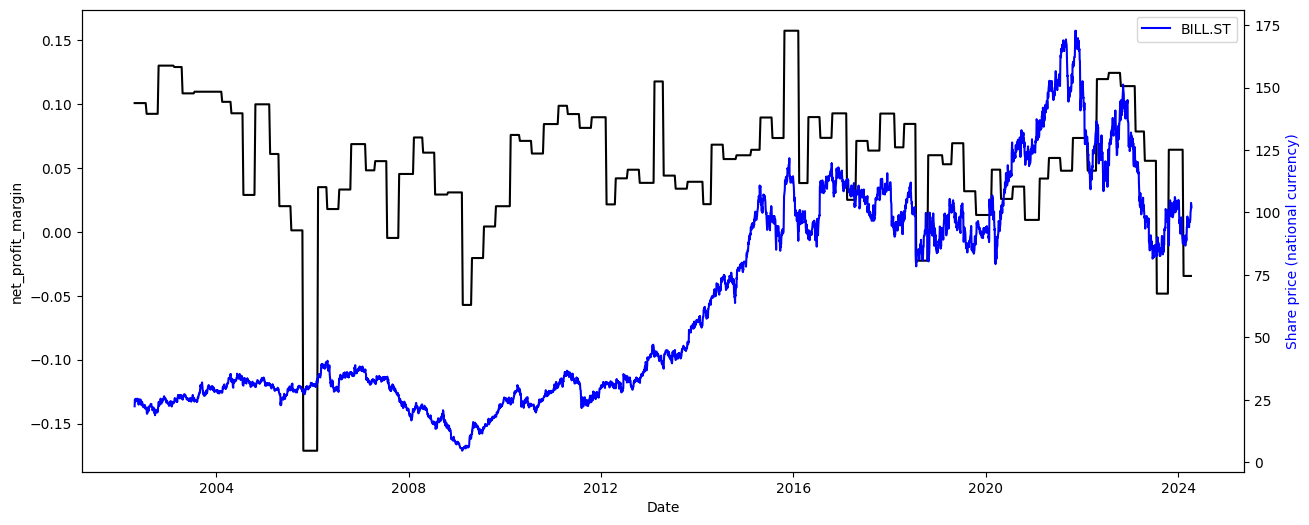

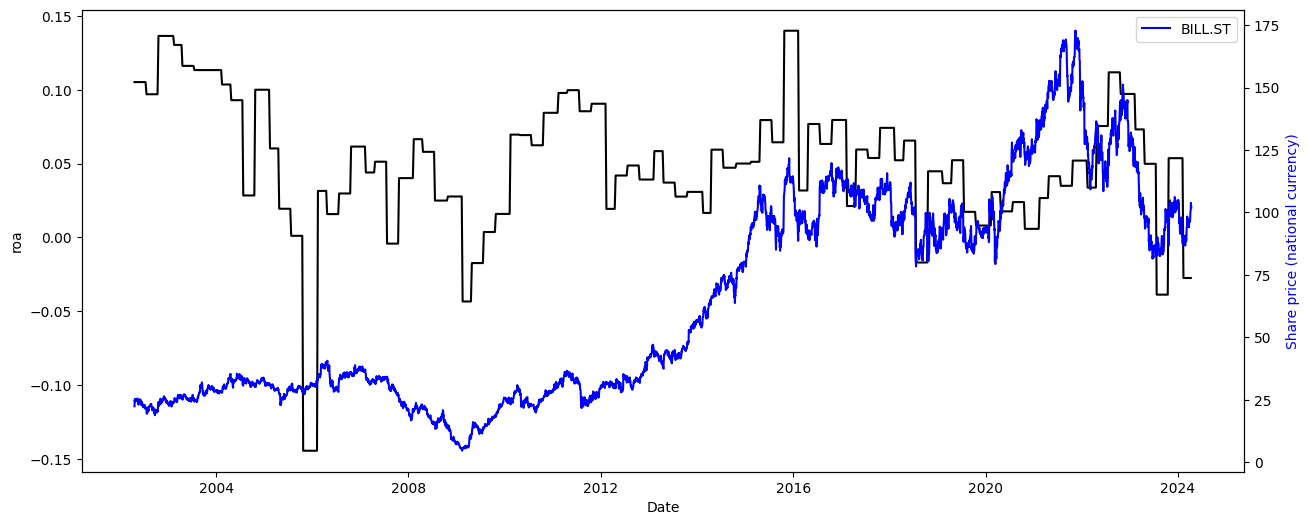

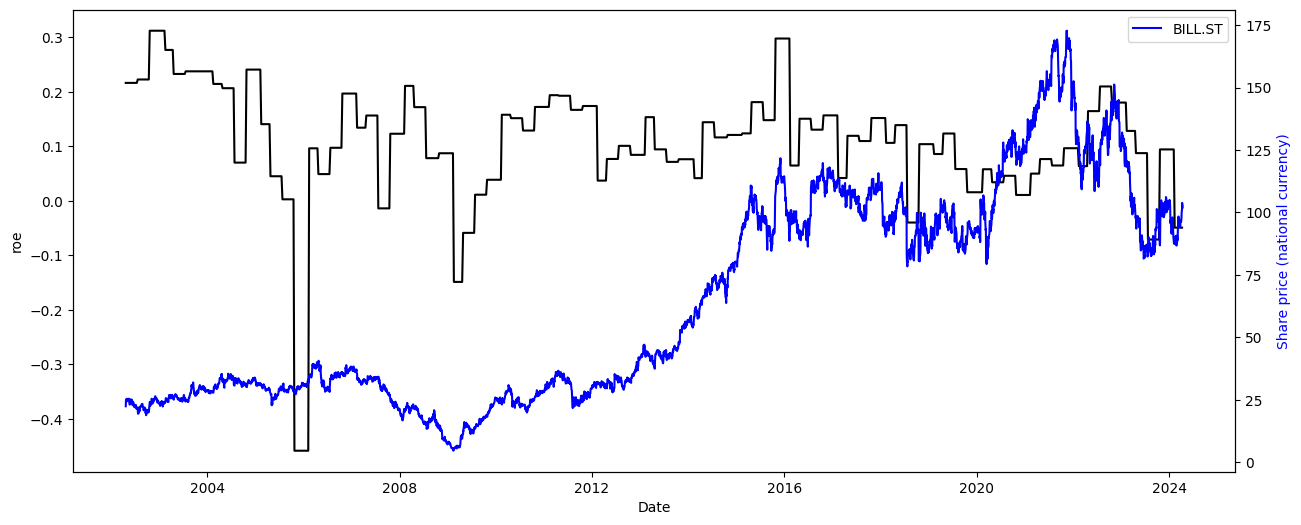

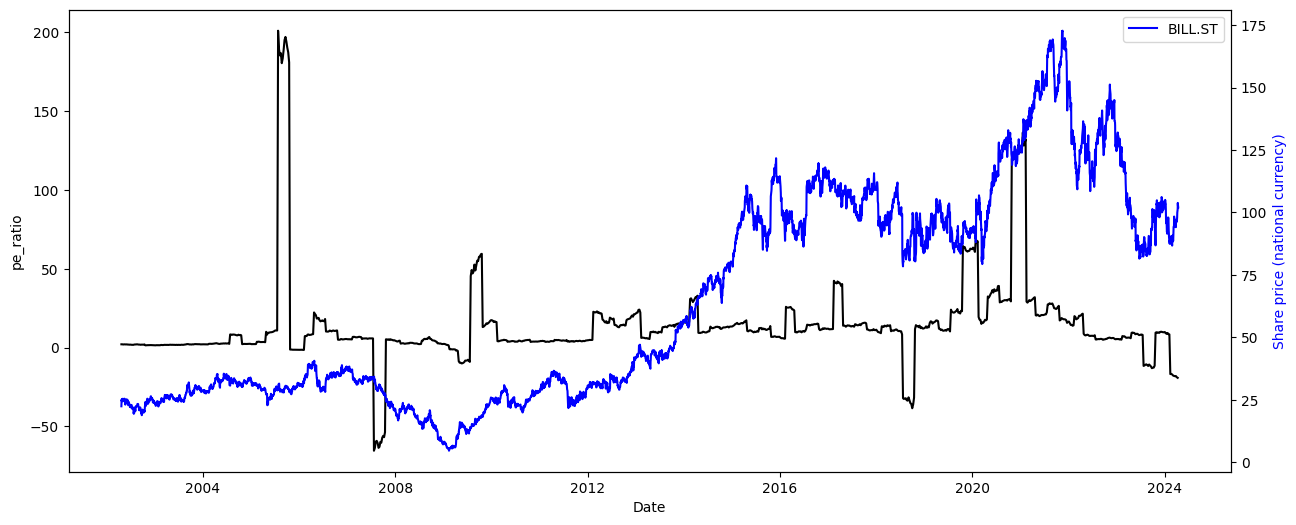

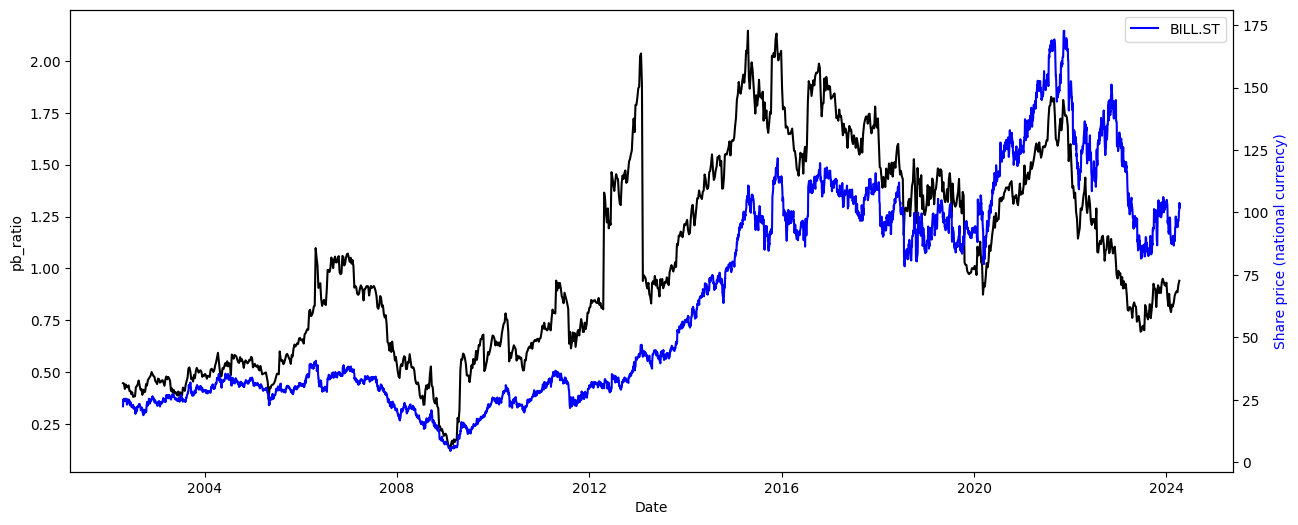

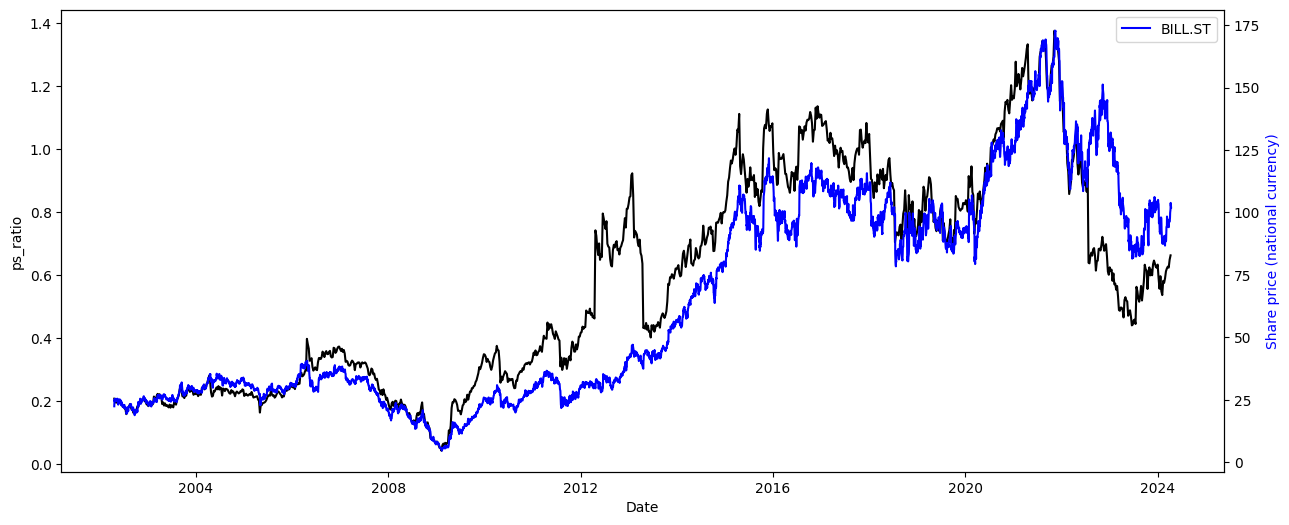

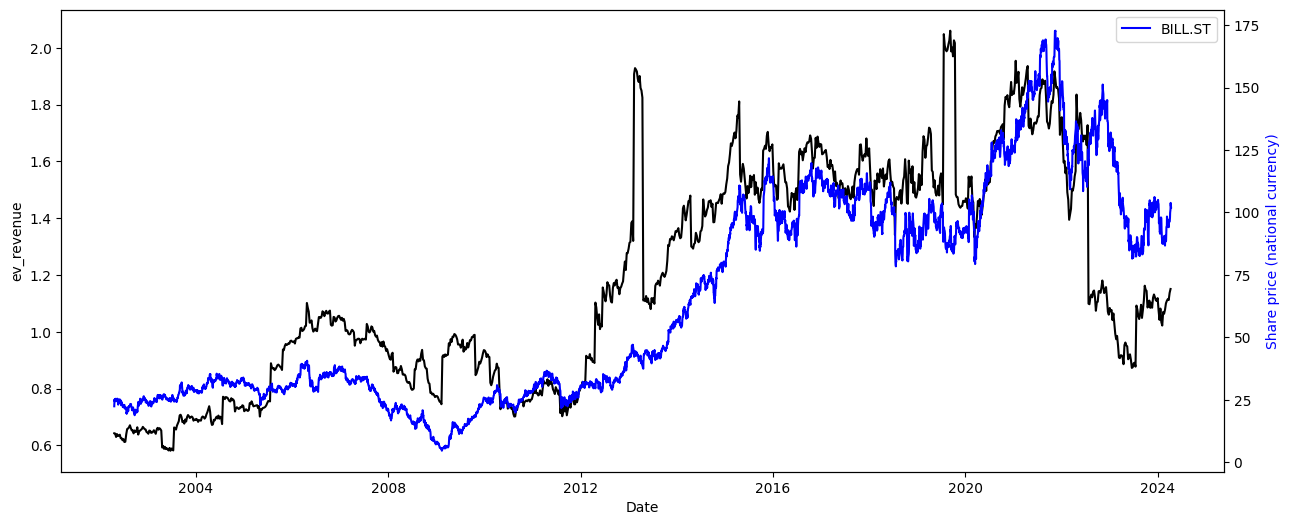

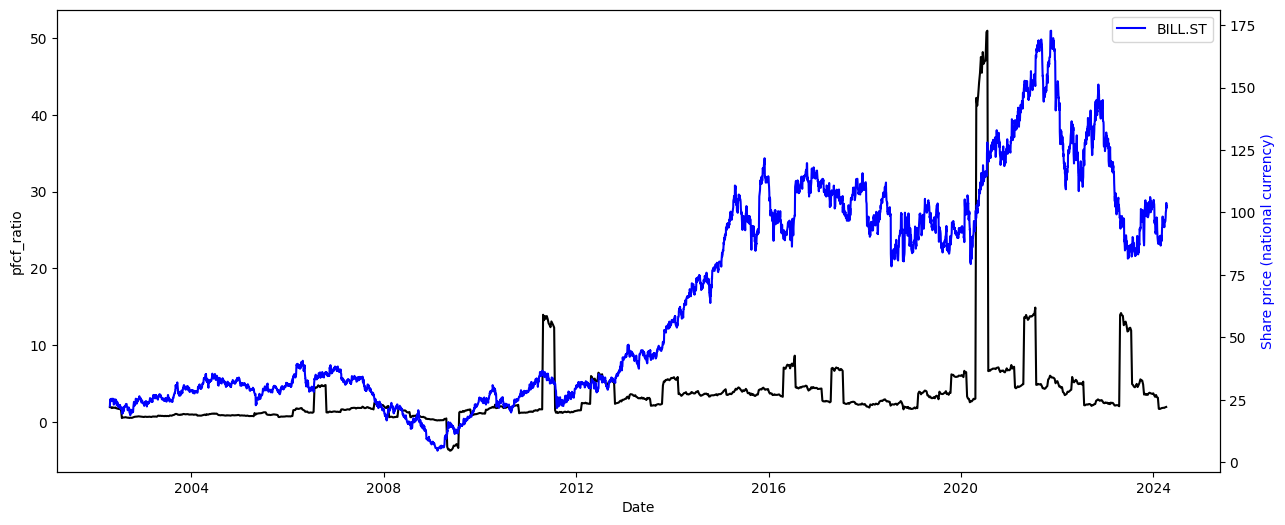

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

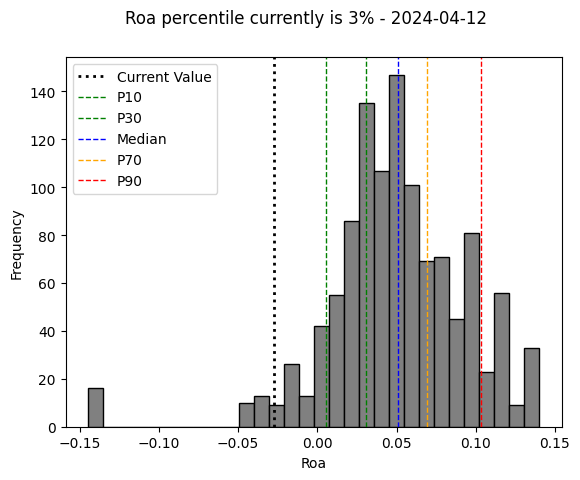

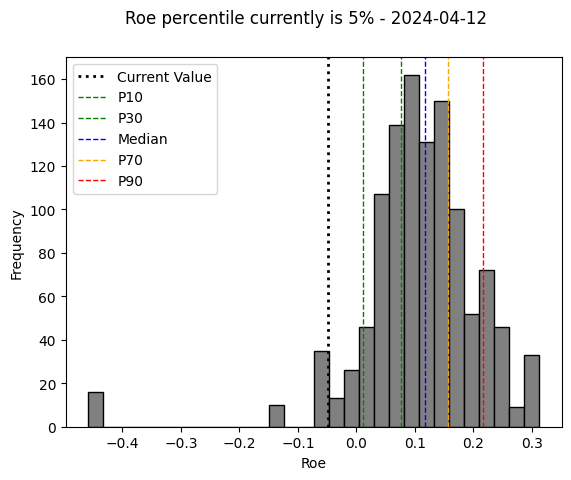

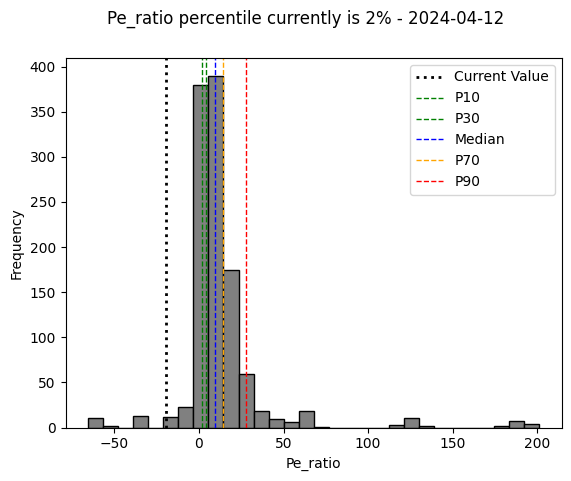

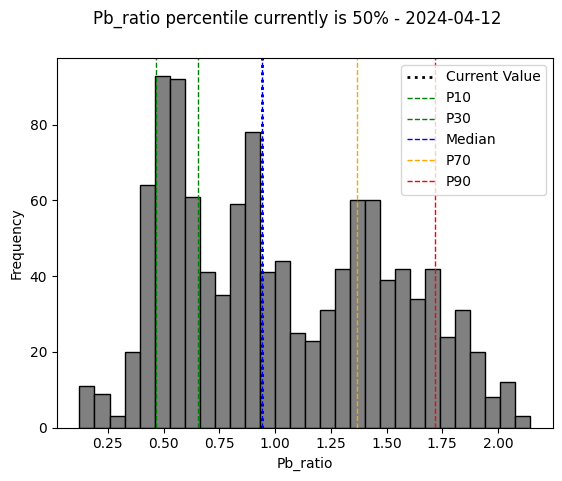

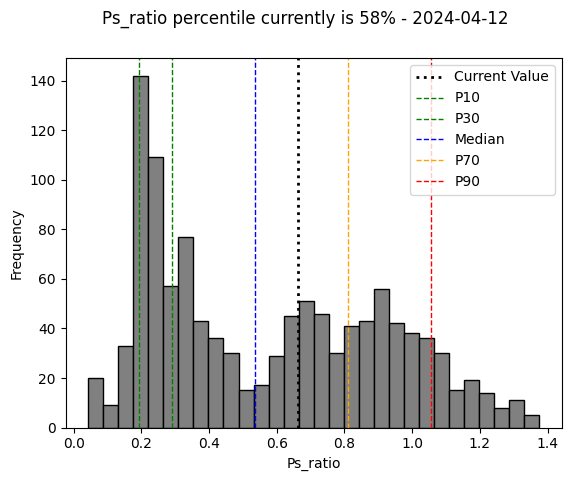

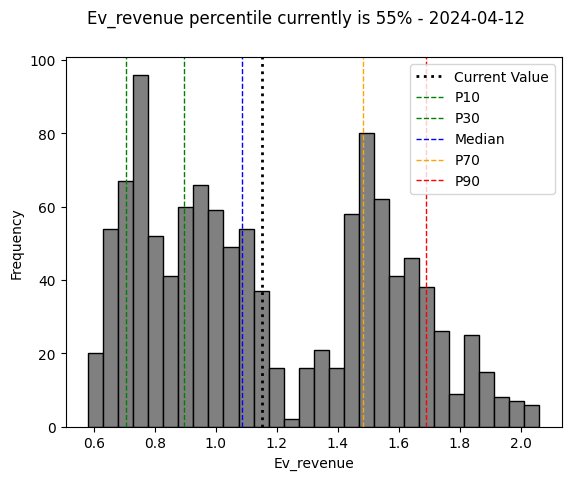

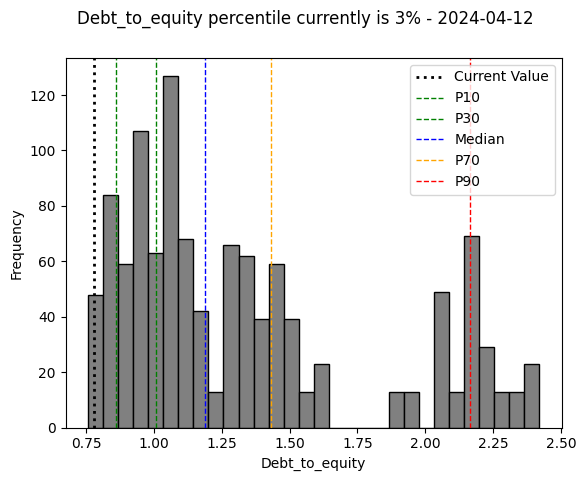

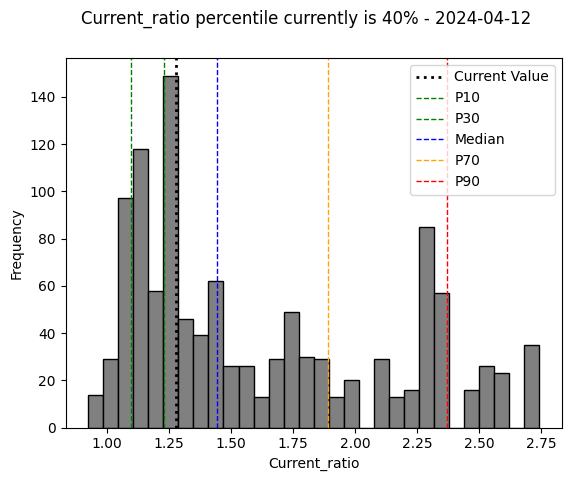

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.971275,-0.162909,0.013442,-0.024317,-0.200771,-0.397623,0.170125
roe,0.971275,1.000000,-0.143504,0.003078,-0.053634,-0.184366,-0.279936,0.153454
pe_ratio,-0.162909,-0.143504,1.000000,0.146307,0.243095,0.251525,-0.065821,-0.010457
pb_ratio,0.013442,0.003078,0.146307,1.000000,0.920911,0.868477,-0.344020,-0.598771
ps_ratio,-0.024317,-0.053634,0.243095,0.920911,1.000000,0.921663,-0.517691,-0.562381
ev_revenue,-0.200771,-0.184366,0.251525,0.868477,0.921663,1.000000,-0.199035,-0.627699
debt_to_equity,-0.397623,-0.279936,-0.065821,-0.344020,-0.517691,-0.199035,1.000000,0.111630
current_ratio,0.170125,0.153454,-0.010457,-0.598771,-0.562381,-0.627699,0.111630,1.000000


0 timestemos have been found!


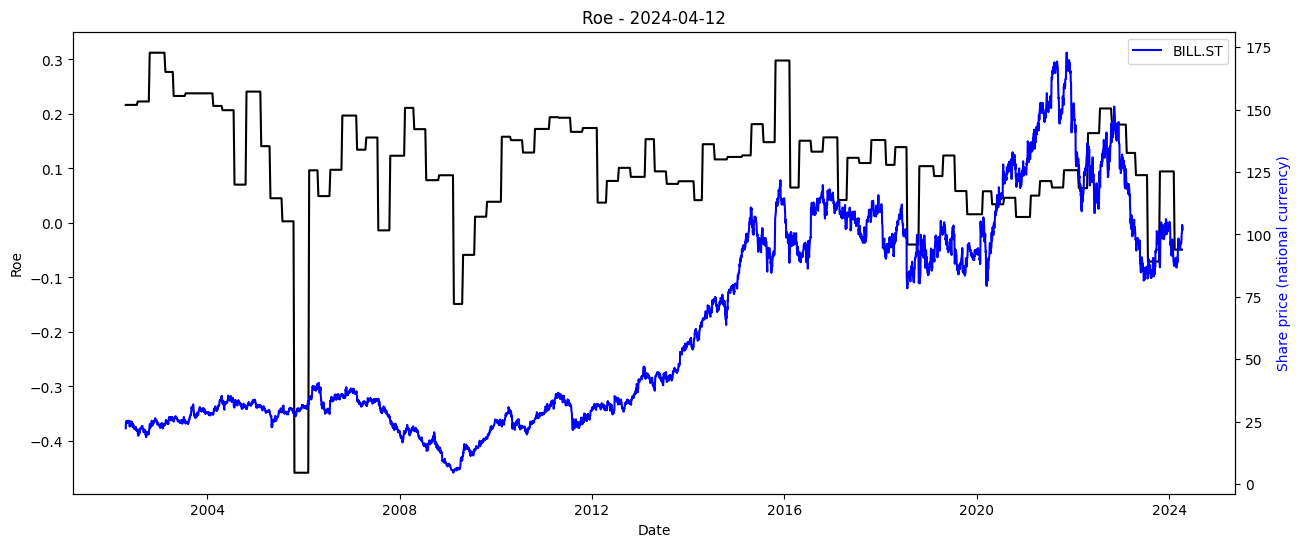

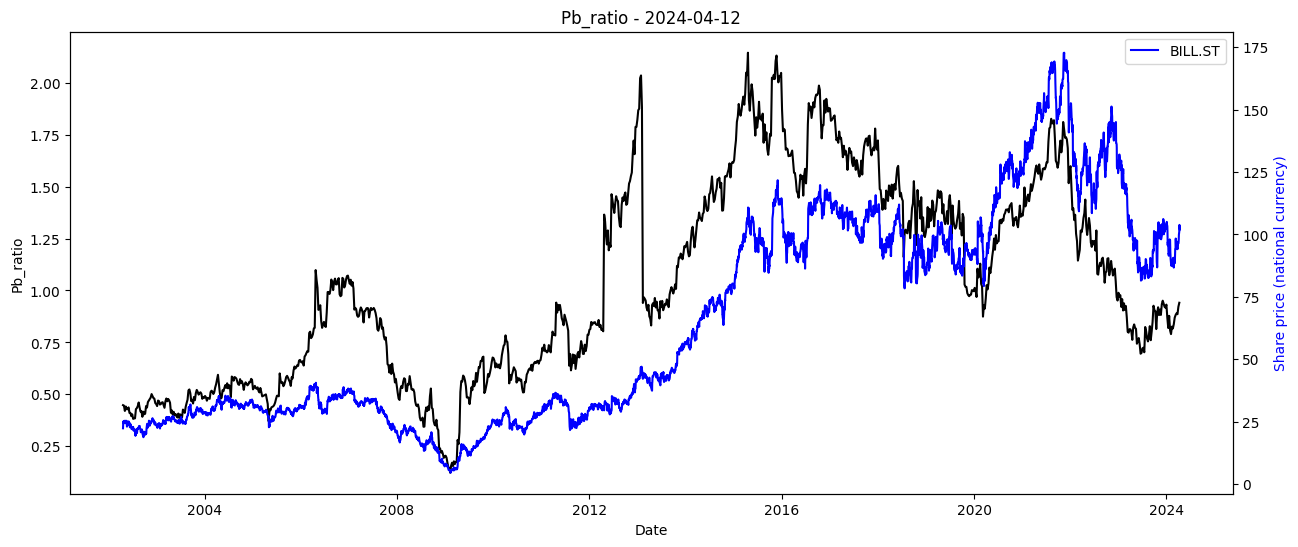

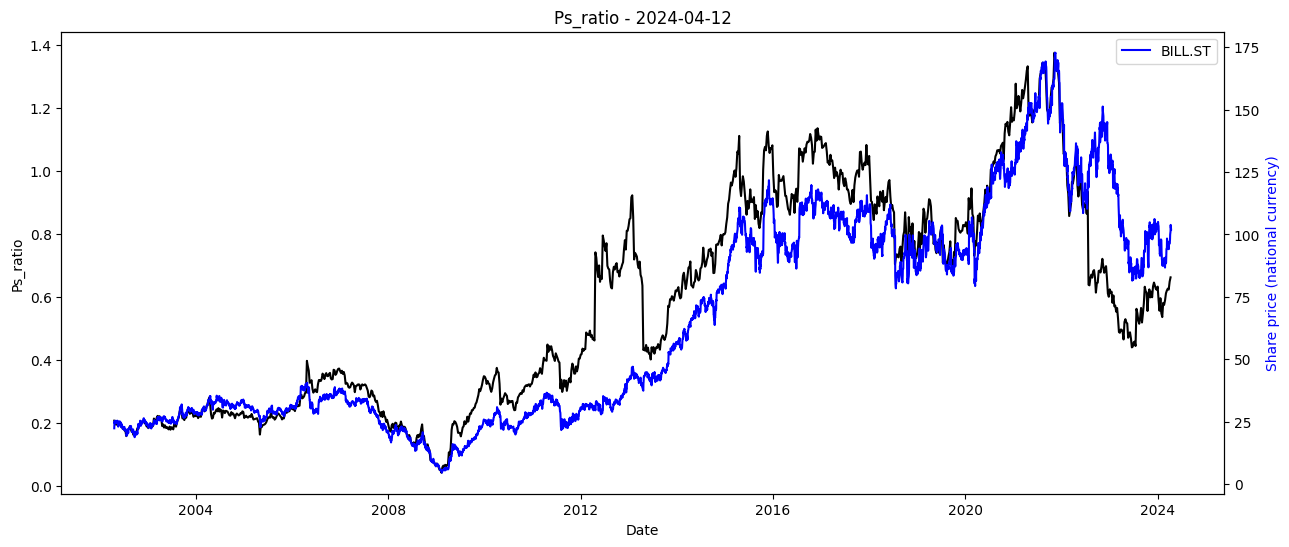

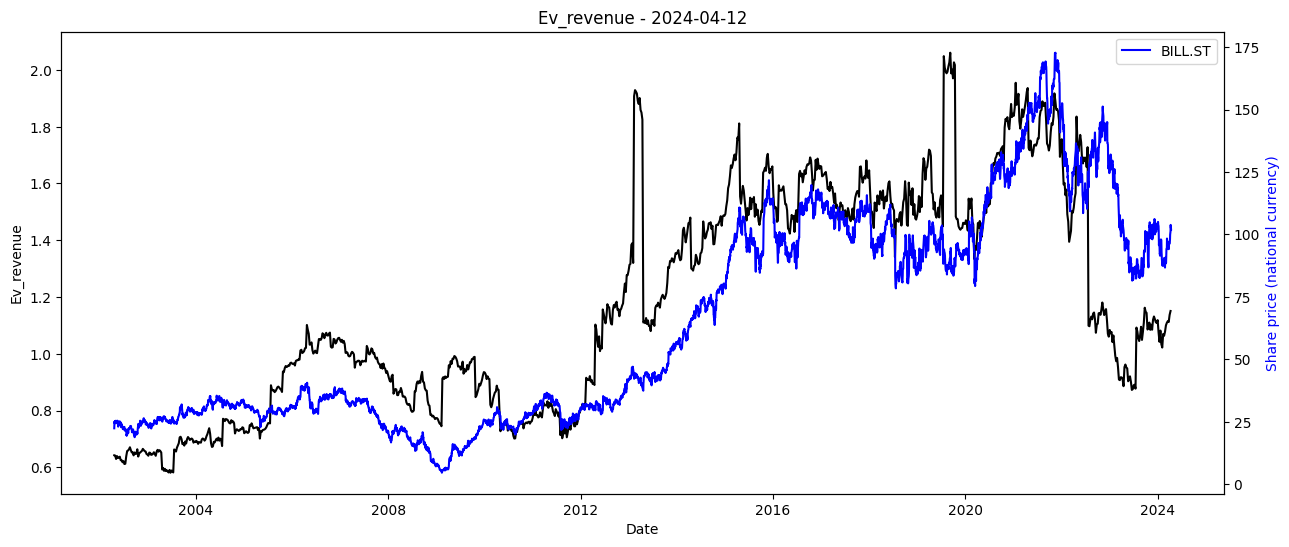

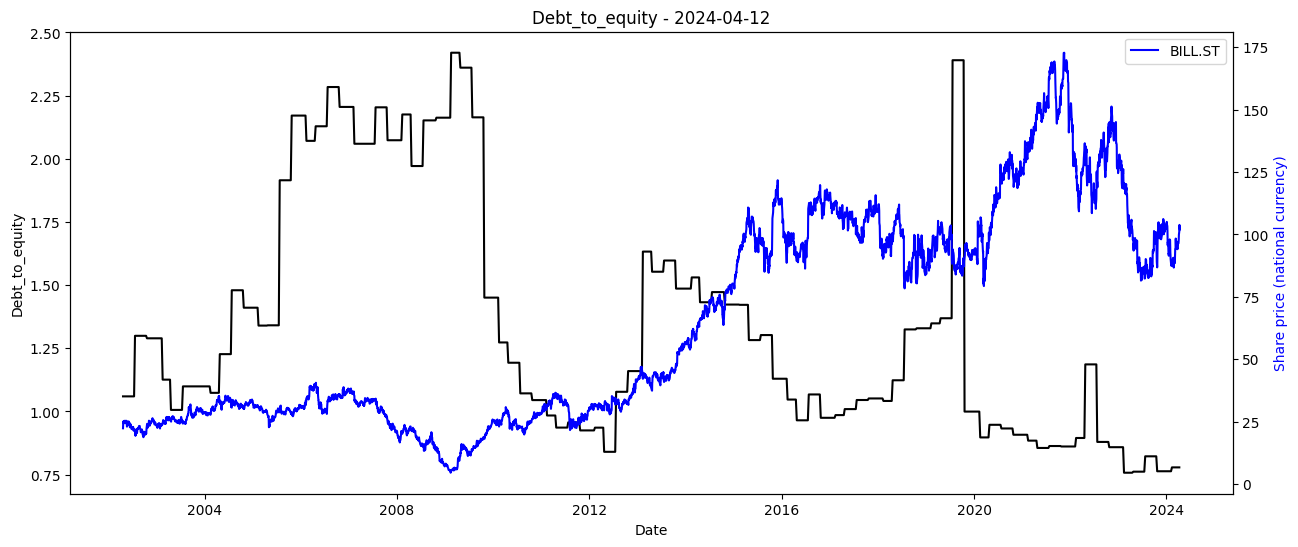

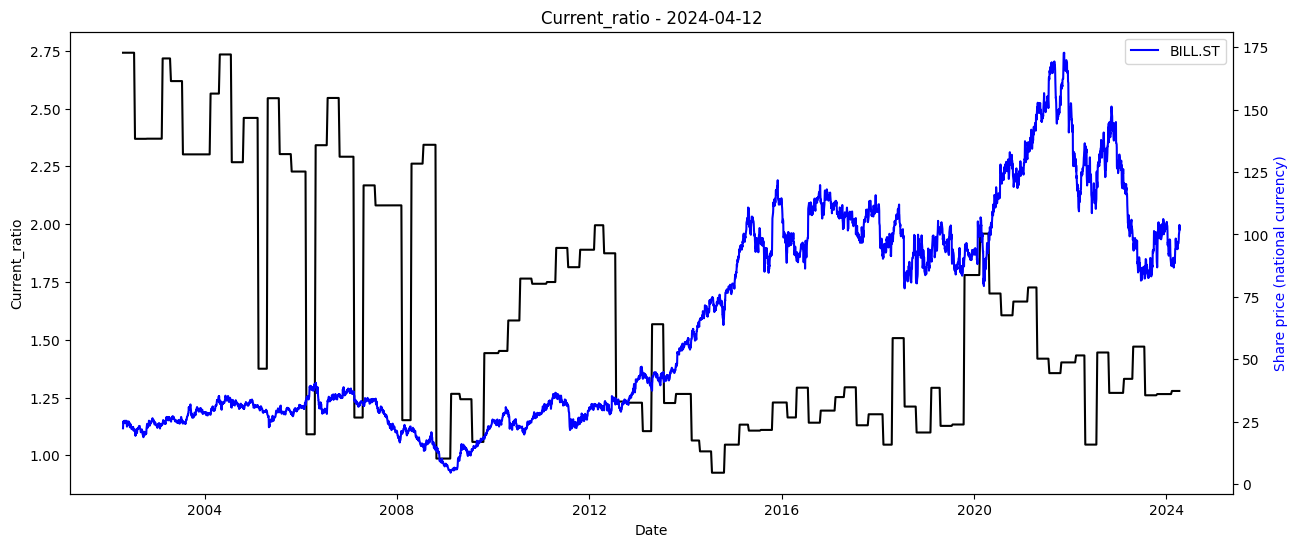

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )